
### What does this notebook do? 

This notebook steps you through how to load in and plot up data from Sentinel 2. It explores the data that are available from the Sentinel 2 satellite, and briefly describes the Sentinel satellite bands. It then loads in the `s2a_ard_granule` product and plots it up in true and false colour. It uses the provided pixel quality data to filters the example scene based on cloud and cloud shadow-free pixels.


###### Specifics

- Converting a DEA notebook example to use GSKY instaed of datacube.

- Uses WCS to get an area from a specified layer/date/bbox/time, and differs from the DEA example.

- Only one time slice can be used in WCS. 
    - You can choose from all available times in the layer.
    - Only 2 time slices have valid BBoxes hard coded. 
    - The fourth time uses the whole of Australia.

- If you can determine a valid BBox for a date (Tip: Use TerriaMap) it can be manually typed in.

- The DEA example, using datacube, can get the data for a time range. It is not possible in GSKY.

**Author:** Arapaut V. Sivaprasad

**Date:** 11 February, 2020

In [1]:
##########################################################
# Author: Arapaut V. Sivaprasad.                         #
# Dates: Created: 23/10/2019; Last Modified: 11/02/2020  #
##########################################################
# GSKY-specific imports
from owslib.wcs import WebCoverageService
import matplotlib.pylab as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import logging, sys
logging.disable(sys.maxsize)


### GSKY server and layer name

The GSKY Capability Endpoint URL is specified in the cell below. A layer must also be hard coded. You can display all layers in the dataset and choose any layer.

In [2]:
# Specify the GSKY production URL here. The layer is hard coded
gsky_url = 'https://gsky.nci.org.au/ows/dea'
layer = "sentinel2_nbart_daily"
# layer = "landsat8_nbar_16day"
wcs = WebCoverageService(gsky_url, version='1.0.0')

# Uncomment below to see all layers.
#for layer in list(wcs.contents):
#    print ("Layer Name:", layer)
#    print ("Title:", wcs[layer].title, '\n')

### Time position

To get the data it is necessary to send a single time position. You can uncomment a line to display all vailable time positions.

In [3]:
# To display the available time slices in any range, specify the start and end values as m,n below
time = wcs[layer].timepositions
n_times = len(time)
m = 0
n = n_times
# print ("Total of", n_times,'timepositions:\n\n', time[m:n])

# Unlike in the case of datacube, where a time range can be specified, GSKY requires a specific date.
# This specific time slice is specified below. 
t = n-1
wcs[layer].timepositions[t]

'2019-12-06T00:00:00.000Z'

### Specify a bounding box

To specify an area to analyse, you must give its bounding box coordinates (in EPSG:4326). This can be done either by hard coding it as e.g. *BBoxes[0] = ['148.62,-35.14,149.32,-36.58']* or by giving a tile ID(s) to calculate the BBox. Only one BBox can be specified in a WCS query.

The tiles are approximately 1x1 degree areas the Australian continent is divided into. A list of these tiles and their bounding boxes can be seen by uncommenting its code below. For instance, tiles '15_-40' and '15_-41' together cover all of ACT plus some of the surroundings. Sydney is covered by '17_-39'. 

Click [here](http://cmi.ga.gov.au/sites/default/files/2017-12/DEA%20Tiles_1.pdf) to view the tile map.


In [4]:
tiles_list = {}
with open("tiles_bboxes.txt") as f:
    for line in f:
        (key, val) = line.split()
        tiles_list[str(key)] = val

# Uncomment below to see all tiles and ther BBoxes
# tiles_list

#### Select a tile to get its BBox, after verifying that the tile has some data for the chosen layer and time. (Tip: use TerriaMap to find out)

You can give a single tile as **" tiles = \['-11_-38'\] "** or two tiles as in **" tiles = \['-11_-38','-11_-40'\]"**, where the first tile is the top left corner and the second tile is the bottom right corner of the area to be plotted. The BBox will be generated from these and scaled to fit the plot. 


In [5]:
# Give two tiles as [top left corner, bottom right corner]
#tiles = ['9_-36','10_-37'] # https://gsky.nci.org.au/ows/dea - Prod GSKY server
# tiles = ['8_-32','9_-33']  # http://130.56.242.15/ows/ipynb   - Dev GSKY server
tiles = ['12_-47', '12_-47'] # Sentinel 2 bands
bbox = [tiles_list[tiles[0]],tiles_list[tiles[1]]]

# If you know another BBox containing data (Tip: use TerriaMap to find out) then type it in below.
#bbox = ['130.00,-27.00,131.00,-29.00']

x = float(bbox[0][0:6])
y = float(bbox[0][7:13])
X = float(bbox[1][14:20])
Y = float(bbox[1][21:27])

# The longitude dimension is adjusted to fit the plot size of 337*220 pixels
X = float('%.2f'%(x + ((abs(Y - y) / 220) * 337)))
bbox = (x,y,X,Y)
bbox

(146.07, -41.36, 147.63, -42.38)

# Sentinel 2 bands

Sentinel 2 satellites have 13 spectral channels. 


<img src='images/sentinel2_bands.png' width="600">


Though the data from datacube returns all the above bands, the GSKY server can return only those specified in '*config.json*' for a namespace (e.g. 'dea'). The production server is set to send only the "*red,green,blue*" as true colors and "*nbart_swir_2,nbart_nir_1 and nbart_green*" as false colors. 

On this page we are plotting both the true color and false color bands. Since the GSKY server can only return 3 bands of either type, we make two separate calls to the GSKY server. 

    1. nbart_red
    2. nbart_green
    3. nbart_blue
    4. nbart_nir_1
    5. nbart_nir_2
    6. nbart_swir_2
    7. nbart_swir_3
    8. nbart_coastal_aerosol
    9. nbart_red_edge_1
    10. nbart_red_edge_2
    11. nbart_red_edge_3

These bands cover the visible, near-infrared and short-wave infrared wave lengths.

<img src='images/Sentinel2_Spectral_Bands.jpg' width="600">


### Get the data from GSKY server using the WCS service

The call below asks for the True Color bands (red, green, blue) and False Color bands (nir, swir1, swir2). GSKY always labels the bands as Band 1, 2 and 3. These are taken into variables of appropriate names.

In [6]:
# Construct the URL for a WCS call and send it to the GSKY server.
# Style can be False Color (fc) or True Color (tc)
# This NB uses only NetCDF and EPSG:4326. Hence, do not change these.
# If any error, the displayed URL can be opened in a browser to see the actual error message.
output = wcs.getCoverage(identifier=layer, Styles='tc',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)
# Read the output into diskless NetCDF
nc = Dataset('dtemp.nc','r',diskless=True,persist=False, memory=output.read())
red = nc.variables['Band1'][:]
green = nc.variables['Band2'][:]
blue = nc.variables['Band3'][:]

# print(output.geturl())
output = wcs.getCoverage(identifier=layer, Styles='fc',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)
# Read the output into diskless NetCDF
nc = Dataset('dtemp.nc','r',diskless=True,persist=False, memory=output.read())
swir2 = nc.variables['Band1'][:]
nir1 = nc.variables['Band2'][:]
green = nc.variables['Band3'][:]

print(output.geturl())
nc

http://gsky.nci.org.au/ows/dea?version=1.0.0&request=GetCoverage&service=WCS&Coverage=sentinel2_nbart_daily&BBox=146.07%2C-41.36%2C147.63%2C-42.38&time=2019-12-06T00%3A00%3A00.000Z&crs=EPSG%3A4326&format=NetCDF&width=256&height=256&Styles=fc


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.5
    GDAL: GDAL 3.0.1, released 2019/06/28
    history: Tue Feb 11 13:58:12 2020: GDAL Create( /local/gsky-tmp/raster_101813865, ... )
    dimensions(sizes): lon(256), lat(256)
    variables(dimensions): int16 Band1(lat,lon), int16 Band2(lat,lon), int16 Band3(lat,lon), |S1 crs(), float64 lat(lat), float64 lon(lon)
    groups: 

# Plot the data

The data returned by GSKY server (Production version) contains only three bands. Depending on the chosen style ('tc' or 'fc') it will be the visible (red, green, blue) or invisible (nir, swir) spectrum. To get all these bands it is necessary to set the GSKY config (config.json) to include all available bands in the NetCDF output.

The various spectral bands are plotted below.

## Plot as a true colour image

True colour images approximate what the human eye sees when looking at a landscape. Note that the function used for this true colour plot enhances the contrast between the bands, resulting in a colour-enhanced image.

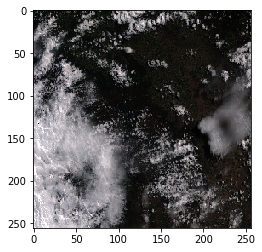

In [7]:
# Stack the three bands together and cast it as float32
# In the line below the 'axis=2' ensures that the data shape is 256,256,3
# rgb = np.stack([nc.variables['Band%d' % (b+1)] for b in range(3)], axis=2).astype(np.float32)
rgb = np.stack([red, green, blue], axis=2).astype(np.float32)

# Convert all values into a range from 0 to 1. This is important.
rgb /= rgb.max()
# print(rgb)
# Uncomment next line to see the data values.

# Plot it
imgplot = plt.imshow(rgb)
plt.show()


## Plot as a false colour image

This plot uses the SWIR2, nir1 and green  bands.

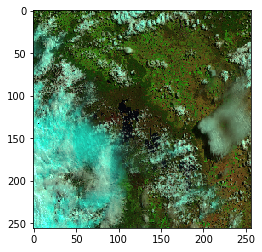

In [8]:
# Stack the three bands together and cast it as float32
# In the line below the 'axis=2' ensures that the data shape is 256,256,3
# rgb = np.stack([nc.variables['Band%d' % (b+1)] for b in range(3)], axis=2).astype(np.float32)
rgb = np.stack([swir2, nir1, green], axis=2).astype(np.float32)

# Convert all values into a range from 0 to 1. This is important.
rgb /= rgb.max()

# Uncomment next line to see the data values.
# print(rgb)

# Plot it
imgplot = plt.imshow(rgb)
plt.show()

`Copyright` &copy; `2019 by National Computational Infrastructure (NCI).`